## Introduction to Likelihood Ratio Tests (LRTs)

A common problem after we've found the maximum-likelihood estimate (MLE) of some parameter, $\mu$, is to ask whether alternative values have a likelihood so much lower than the maximum that we can exclude them as reasonable possibilities. More formally, in a frequentist framework, we'd like to know if we can reject a possible value of $\mu$ at $\alpha=0.05$. For example, based on our reading of previous literature about populations of salamanders around the US, we might expect that the average snout-to-vent (SVL) lengths of salamanders in our local population is 5.6 cm. To see if we have smaller or larger salamanders than the rest of the country, we go collect 15 of them and get the following lengths:

In [1]:
sallieSVLs = [5.94,5.89,7.31,5.98,6.27,5.00,5.29,6.79,5.19,5.54,6.83,6.20,6.51,5.33,6.08]

Since length is a continuous trait that is probably controlled by many genes of small effect, it might be reasonable to model SVLs in our population with a normal distribution. For the moment, we're going to assume that the variation in lengths (i.e., standard deviation, sd) is the same as other populations ($sd=0.7$) and we're interested in estimating the mean ($\mu$). Ok, now we need a way to calculate the likelihood for our normal model. We'll make the additional assumption that the length of each salamander is roughly independent, because they're not closely related. In that case, we can calculate the likelihood for the sample as a whole by taking the product of the likelihoods for each length:

In [2]:
from scipy.stats import norm

def like(data,mean,sd=0.7):   # Assuming standard deviation is known (0.7).
    """
    This function takes data as a list of continuous values and calculates the joint
    probability of those values assuming they are independent draws from a Normal
    distribution with the specified mean and standard deviation.
    """
    try:               # Note the use of the try...except pair to catch errors
        like = 1
        for d in data:
            like *= norm.pdf(d,loc=mean,scale=sd)
        return like
    except:
        print("You provided non-numeric data to the likelihood function. Try again...")
        raise

Now we need an algorithm that will find our MLE and associated likelihood. Here's the basic one we talked about in class:

In [3]:
def hillClimb (data,param):
    """
    This hill-climbing function will find the maximum-likelihood estimate and score by
    relying on a function called like() to calculate likelihoods. It is only set up to 
    explore values of one parameter. The data can be defined in any way, as long as they
    are consistent with what the like() function expects.
    """
    
    diff = 0.1
    pCurr = param
    
    while ( diff > 0.001):
        L_pCurr = like(data,pCurr)
        L_pUp = like(data,pCurr+diff)
        L_pDown = like(data,pCurr-diff)

        while ( L_pUp > L_pCurr ):
            pCurr = pCurr + diff
            L_pCurr = like(data,pCurr)
            L_pUp = like(data,pCurr+diff)
            L_pDown = like(data,pCurr-diff)

        while (L_pDown > L_pCurr ):
            pCurr = pCurr - diff
            L_pCurr = like(data,pCurr)
            L_pUp = like(data,pCurr+diff)
            L_pDown = like(data,pCurr-diff)

        diff /= 2

    return (pCurr,L_pCurr)  # Returns tuple with BOTH MLE and likelihood score


Now we'll use our hill-climbing function to find the MLE and associated maximum likelihood for our salamander SVL data. We'll start our search at the expected mean based on our previous reading.

In [4]:
svlML = hillClimb(sallieSVLs,5.6)
print("The MLE is %.2f cm with likelihood score %.4E." % svlML)

# Note the Python string formatting used above. Each of the elements in the string
# beginning with % indicates a placeholder for a value. These values are stored in the svlML
# tuple that follows after the string. A "%f" element indicates a float. A "%.2f" element
# indicates a float rounded to 2 decimal places. A "%E" element indicates a number with 
# scientific notation. Similarly, "%.4E" indicates scientific notation with 4 decimal places.


The MLE is 6.01 cm with likelihood score 3.7170E-07.


Interesting! The normal distribution that best fits our salamander SVL data has an MLE for the mean (6.01) that is larger than what we expected based on our previous reading (5.60). Let's compare the likelihood for the MLE to the likelihood for our _a priori_ expectation.

In [5]:
print("The likelihood score for our expected mean of 5.6 cm is: %.4E" % like(sallieSVLs,5.6))

The likelihood score for our expected mean of 5.6 cm is: 2.8364E-08


Ok, makes sense. The likelihood for our previous expectation is lower than that of the MLE we estimated. But how much lower is it? Let's calculate the ratio of these likelihoods

In [6]:
print("The likelihood ratio is: %f" % (like(sallieSVLs,6.01)/like(sallieSVLs,5.6)) )

The likelihood ratio is: 13.104546


Hmmmm, the probability of observing our set of 15 SVLs is 13 times higher for our MLE than our previous expectation. That seems like a lot. Is it enough to say that we can reject the average we took from the literature and confidently assert that we have larger salamanders? As it turns out there's some elegant theory to provide guidance about this, but let's pretend we don't know about that. What could we do to try and figure this out? A tedious, but straightforward way to tackle this is to simulate lots of data sets assuming 5.6 cm is the true mean and see how often we find a likelihood ratio this big. Ok, let's give it a try.

First, we'll need to simulate a bunch of datasets with 15 lengths drawn from a normal with mean=5.6 and sd=0.7.

In [7]:
datasets = []

# Set the number of simulations. More simulations = greater precision, but more time.
numReps = 1000 

for _ in range(numReps):
    datasets.append(norm.rvs(loc=5.6,scale=0.7,size=15))

Ok, now that we've got all of these datasets, let's calculate their likelihoods for the true mean used in the simulations.

In [8]:
trueLikes = []

for rep in range(numReps):
    trueLikes.append(like(datasets[rep],mean=5.6))

Now, let's find the MLE for each dataset and record the associated maximum likelihood.

In [9]:
maxLikes = []

for rep in range(numReps):
    if rep % 25 is 0:
        print(" %s " % rep,end="")
    MLvals = hillClimb(datasets[rep],5.6)
    maxLikes.append(MLvals[1])

 0  25  50  75  100  125  150  175  200  225  250  275  300  325  350  375  400  425  450  475  500  525  550  575  600  625  650  675  700  725  750  775  800  825  850  875  900  925  950  975 

Lastly, we just need to calculate the likelihood ratios across the null simulations.

In [10]:
LRs = []

for rep in range(numReps):
    LRs.append(maxLikes[rep]/trueLikes[rep])

Let's take a look at a histogram of the ratios from our simulations under the null and compare the values to our observed ratio.

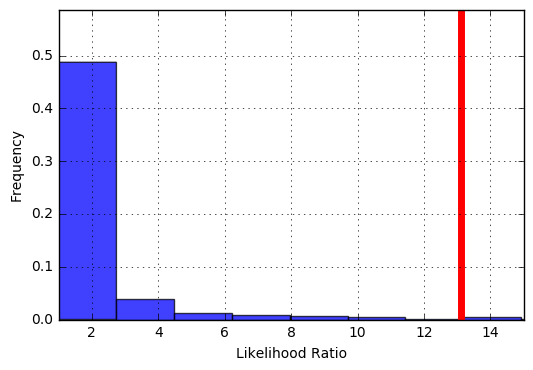

In [11]:
import matplotlib.pyplot as plt

numBins = 1000

n, bins, patches = plt.hist(LRs, numBins, normed=1, facecolor='blue', alpha=0.75)
plt.xlabel('Likelihood Ratio')
plt.ylabel('Frequency')
plt.axis([1, 15, 0, max(n)+0.1])
plt.grid(True)

# A vertical line will indicate the position of our observed LR
obsLR = (like(sallieSVLs,6.01)/like(sallieSVLs,5.6))
plt.plot([obsLR,obsLR], [0, 2], 'r-', lw=5)

plt.show()

# Empirical likelihood ratio shown in red

Hmmmm, well, our observed value seems a lot larger than most of our simulated values. To be precise, we should ask what proportion of simulated LRs are bigger than our observed.

In [12]:
extCount = 0        # Initializing a counter for the proportion of extreme values
for LR in LRs:
    if LR > obsLR:
        extCount += 1  # Incrementing counter when simulated value greater than observed
extCount/numReps    # Printing the proportion that are greater than our observed.

0.029

As it turns out, there is only a very small probability (< 0.03) of observing a likelihood ratio this big or bigger if the true mean was 5.6 cm. Thus, we can reject 5.6 cm as our mean at an $\alpha=0.05$. So it seems that our salamanders are likely larger than average!

There's also an interesting pattern here that may not be obvious, but just trust me for a second. First, let's find a value such that only 5% of our simulations have a larger likelihood ratio. This is an estimate of the critical value for $\alpha=0.5$ in the hypothesis test we just conducted.

In [13]:
import math  # Importing math library to calculate logs

LRs_sorted = sorted(LRs) # Sorting our likelihood ratios

# Finding the value in the 95th percentile of our sorted list
critValue = LRs_sorted[round(0.95*len(LRs_sorted))]

print("alpha_0.05 = %s" % critValue)

alpha_0.05 = 8.09155380936


Just for kicks, let's take the log of this value and multiply it by 2

In [14]:
2*math.log(critValue)

4.181641556123902

Now, I realize this is a little out of the blue, but here's a table of critical values for a chi-squared distribution:

http://sites.stat.psu.edu/~mga/401/tables/Chi-square-table.pdf

If you focus on the column for $\alpha=0.05$, you should see one value that looks very similar to the value you calculated above (assuming you used a reasonably large number of simulations). 

$\chi_{0.05}^2 = 3.841$ for $df=1$.

Interesting. Let's take the log of each of our likelihood ratios and multiply them by 2.

In [15]:
LRs_log = [2*math.log(LR) for LR in LRs]

Now, let's plot a histogram for these log-likelihood ratios.

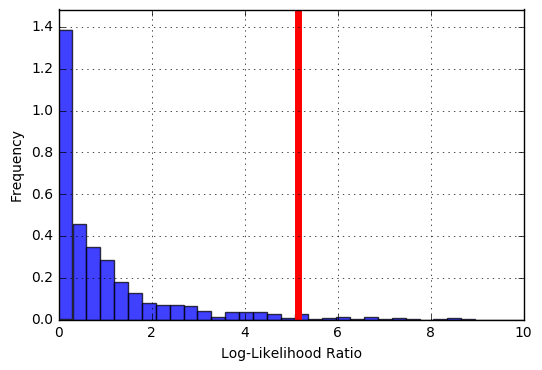

In [16]:
numBins = 50

n, bins, patches = plt.hist(LRs_log, numBins, normed=1, facecolor='blue', alpha=0.75)
plt.xlabel('Log-Likelihood Ratio')
plt.ylabel('Frequency')
plt.axis([0, 10, 0, max(n)+0.1])
plt.grid(True)

# A vertical line will indicate the position of our observed LR
plt.plot([2*math.log(obsLR),2*math.log(obsLR)], [0, 2], 'r-', lw=5)

plt.show()

# Empirical likelihood ratio shown in red

How does this compare to a $\chi_{df=1}^2$ distribution? For comparison, go here
    
https://jeffreyjose.com/stats/dist/
    
then scroll down to the chi-squared distributions and set $df=1$.

It should look pretty similar! As it turns out, when you fit a model that has one estimated (or free) parameter and compare those likelihoods to a model with only fixed parameters, the resulting values for $2*log(LR)$ follow a $\chi^2$ distribution with $df=1$. More generally, anytime you compare nested models* with different numbers of free parameters, the likelihood ratios in the null case follow a $\chi^2$ distribution with _df_ equal to the difference in the number of free parameters between the models. Therefore, we can conduct hypothesis tests in a frequentist framework by calculating likelihood ratios between models and comparing them to the appropriate $\chi^2$ critical value.

*By nested models, we mean that one can recover the model with fewer parameters by simply fixing the values of some parameters in the more complex model.